## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import cv2

import os
import glob
import matplotlib.pyplot as plt
import pickle
from skimage import measure

%matplotlib inline

# Construct array of images

In [71]:
image_test1= plt.imread("./test_images/straight_lines1.jpg")
image_test2= plt.imread("./test_images/test1.jpg")
image_test3= plt.imread("./test_images/test4.jpg")
image_test4= plt.imread("./test_images/test6.jpg")
image_test5= plt.imread("./test_images/test2.jpg")
image_test6= plt.imread("./test_images/test3.jpg")
image_test7= plt.imread("./test_images/test5.jpg")


test_images=[image_test1,image_test2,image_test3,image_test4,image_test5,image_test6,image_test7]

# Calibration & Distortion Correction

# Why is the checkerboard pattern so widely used in calibration?

Checkerboard patterns are distinct and easy to detect in an image. Not only that, the corners of squares on the checkerboard are ideal for localizing them because they have sharp gradients in two directions. In addition, these corners are also related by the fact that they are at the intersection of checkerboard lines. All these facts are used to robustly locate the corners of the squares in a checkerboard pattern. 

In [4]:
def undistort_img():
    
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    # Prepare object points 0,0,0 ... 8,5,0
    #Calibration Boards-> Opencv 9 × 6 asymmetric checkerboard
    obj_pts = np.zeros((6*9,3), np.float32)
    #To initialize 2D array 
    obj_pts[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Creating vector to store vectors of 3D points for each checkerboard image
    objpoints = []
    # Creating vector to store vectors of 2D points for each checkerboard image
    imgpoints = []

    # Get directory recursively for all calibration images
    images = glob.glob('camera_cal/*.jpg')

    for indx, fname in enumerate(images):
        img = cv2.imread(fname)
        #Gray scale conversion
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        #Find 2D coordinates of checkerboard
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        
        ## If desired number of corners are found in the image then ret = true, add object points, image points 
        if ret == True:
            objpoints.append(obj_pts)    # Certainly, every loop objp is the same, in 3D.
            
            #refine the pixel coordinates to increase the precision
            corners2 = cv2.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)
            imgpoints.append(corners)


    # Test undistortion on img
    img_size = (img.shape[1], img.shape[0])

    """
    Performing camera calibration by
    passing the value of known 3D points (objpoints)
    and corresponding pixel coordinates of the
    detected corners (imgpoints)
    """
    ret, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

    #dst = cv2.undistort(img, cameraMatrix, distCoeffs, None, cameraMatrix)
    # Save camera calibration for later use
    dist_pickle = {}
    dist_pickle['mtx'] = cameraMatrix
    dist_pickle['dist'] = distCoeffs
    #storing the image
    pickle.dump( dist_pickle, open('camera_cal/cal_pickle.p', 'wb') )

In [5]:
def undistort(img, cal_dir='camera_cal/cal_pickle.p'):
    #cv2.imwrite('camera_cal/test_cal.jpg', dst)
    with open(cal_dir, mode='rb') as f:
        file = pickle.load(f)
    mtx = file['mtx']
    dist = file['dist']
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst

In [6]:
undistort_img()

Text(0.5, 1.0, 'Undistorted Image')

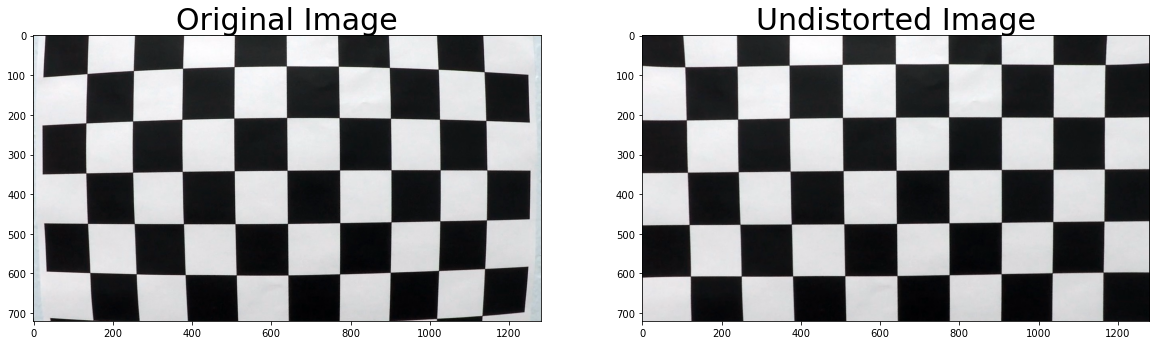

In [7]:
img = cv2.imread('camera_cal/calibration1.jpg')
dst = undistort(img)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

Distortion correction on test images


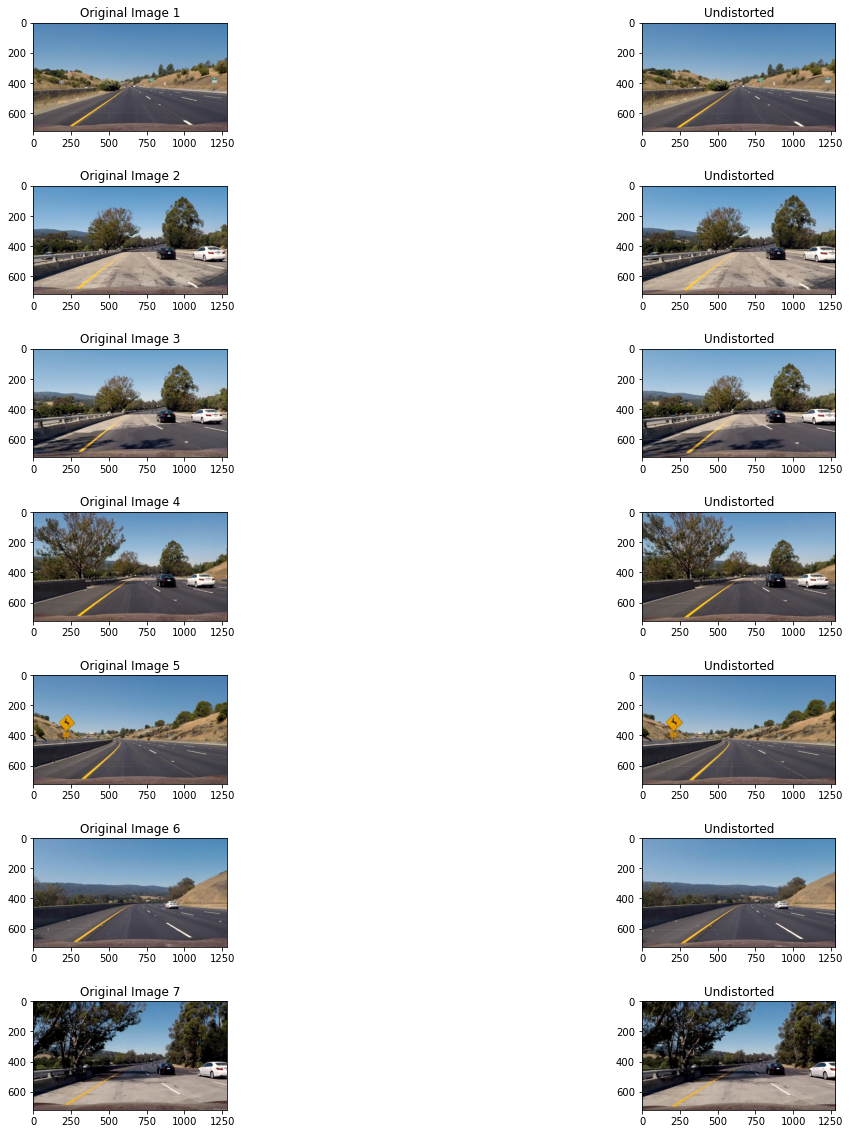

In [8]:

row=0

f,axes= plt.subplots(len(test_images),2, figsize=(20,20))
f.subplots_adjust(hspace=0.5)
print("Distortion correction on test images")

for image in test_images:
    image= cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    y=image.shape[0]
    x=image.shape[1]
    axes[row,0].set_title('Original Image '+str(row+1))
    axes[row,0].imshow(image)
    undistorted_image= undistort(image)
    axes[row,1].imshow(undistorted_image)
    axes[row,1].set_title('Undistorted')
    row+=1

## HLS Functions

In [67]:
'''define function to convert color spase from RGB to HSL
    Goal: adapt sunlight effect'''
def CVt2hls(img):
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    h=hls[:,:,0]
    l=hls[:,:,1]
    s=hls[:,:,2]
    return h,l,s

'''define function to show different hsl channel for image 
    Goal: Figure out which channel is the best for edge detections'''
def tstHLS(test_images):
    row=0
    f,axes= plt.subplots(7,3, figsize=(20,20))
    f.subplots_adjust(hspace=0.5)
    for i in range(0,len(test_images)):
        img=test_images[i]
        h,l,s=CVt2hls(img)
        axes[row,0].imshow(h,cmap="gray")
        axes[row,0].set_title("H channel of test image "+str(i+1))
        axes[row,1].imshow(l,cmap="gray")
        axes[row,1].set_title("l channel of test image "+str(i+1))
        axes[row,2].imshow(s,cmap="gray")
        axes[row,2].set_title("s channel of test image "+str(i+1))
        row=row+1

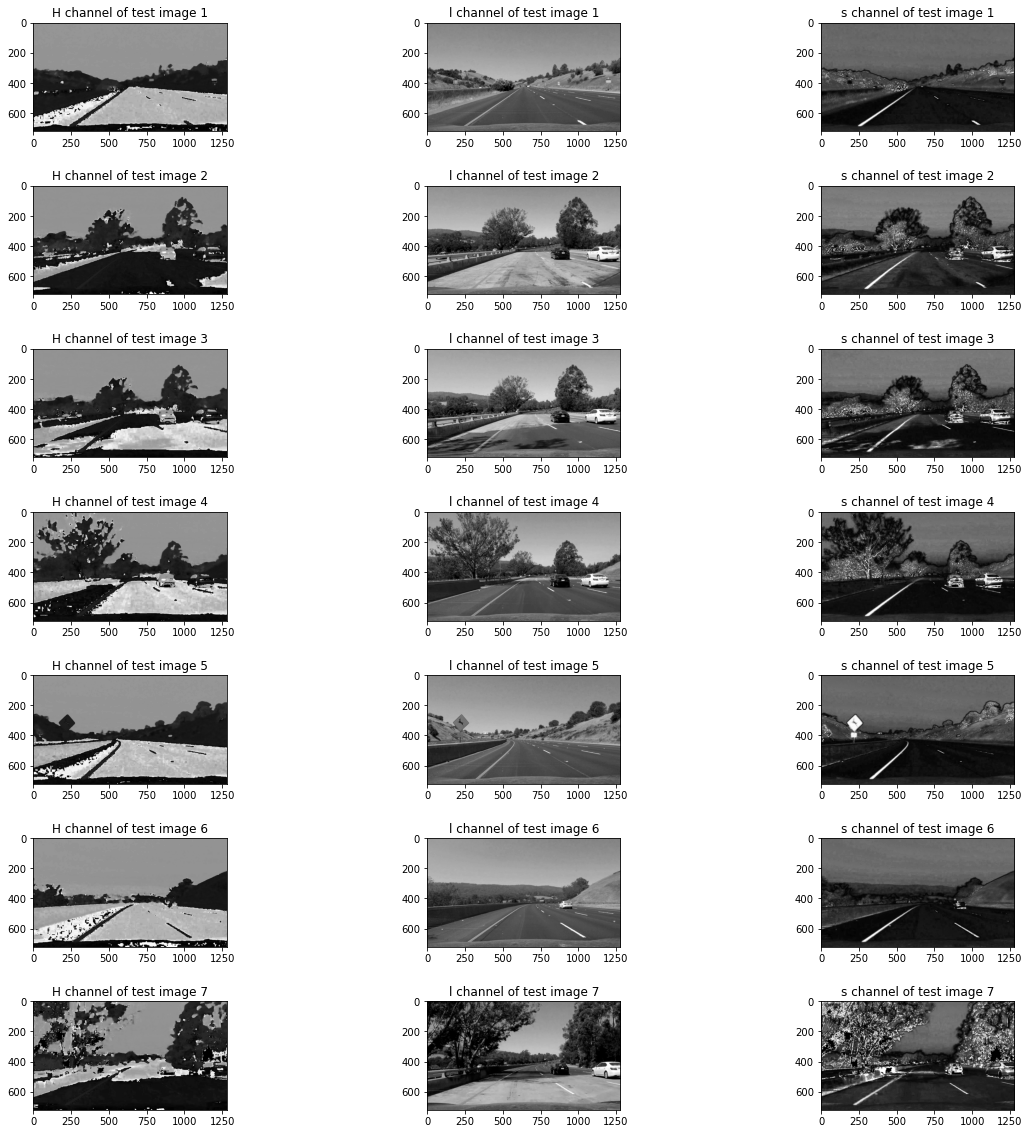

In [68]:
'''testing the array of images'''
tstHLS(test_images)

S channel is the best for edge detection for every image in testing images

# Prespective Transformation Functions

In [52]:
'''function to get the matrix which will multiply to transform our images to bird eye view 
the goal of this step is getting rid of the lane curvature '''
def PerspectiveTransform(Src,Dst):
    M=cv2.getPerspectiveTransform(Src,Dst)
    Minv=cv2.getPerspectiveTransform(Dst,Src)
    return M,Minv
'''function to transform our images with multipling by the transformation matrix (M)  '''
'''INTER_LINEAR parameter refers to the method which resize the output by it with reect to the input image 
    this method depends on 2×2 neighboring pixels to get the weighted average for the interpolated pixel'''
def WarpImg (img,M):
    dsize=(img.shape[1],img.shape[0])
    return cv2.warpPerspective(img, M,(1280,720),cv2.INTER_LINEAR)


In [53]:
'''Now we need to determine the corners of the lane in input image and their coordinates in the output 
    GOAL is getting a bird eye view of lane and look like something like a rectangle'''

'''
src=np.float32([[300,700],[1075,700],[750,450],[620,450]])
dst=np.float32([[190,700],[1075,700],[1000,0],[200,0]])
-----------------------------------------------------------
src=np.float32([[200,700],[1200,700],[700,450],[595,450]])
dst=np.float32([[200,700],[1000,700],[700,450],[200,0]])'''

'''
by try and error we conclude somethings we should put them in consideration such the ratio of the offset 
for each point with respect to the size image'''
'''And by trying different values of offset we find that offset=200 is good'''    


offset=200
height, width= image_test1.shape[0],image_test1.shape[1]
src=np.float32([(595,450),(700,450),(1200,700),(200,700)])
dst=np.float32([(offset,0),(width-offset,0),(width-offset,height),(offset,height)])



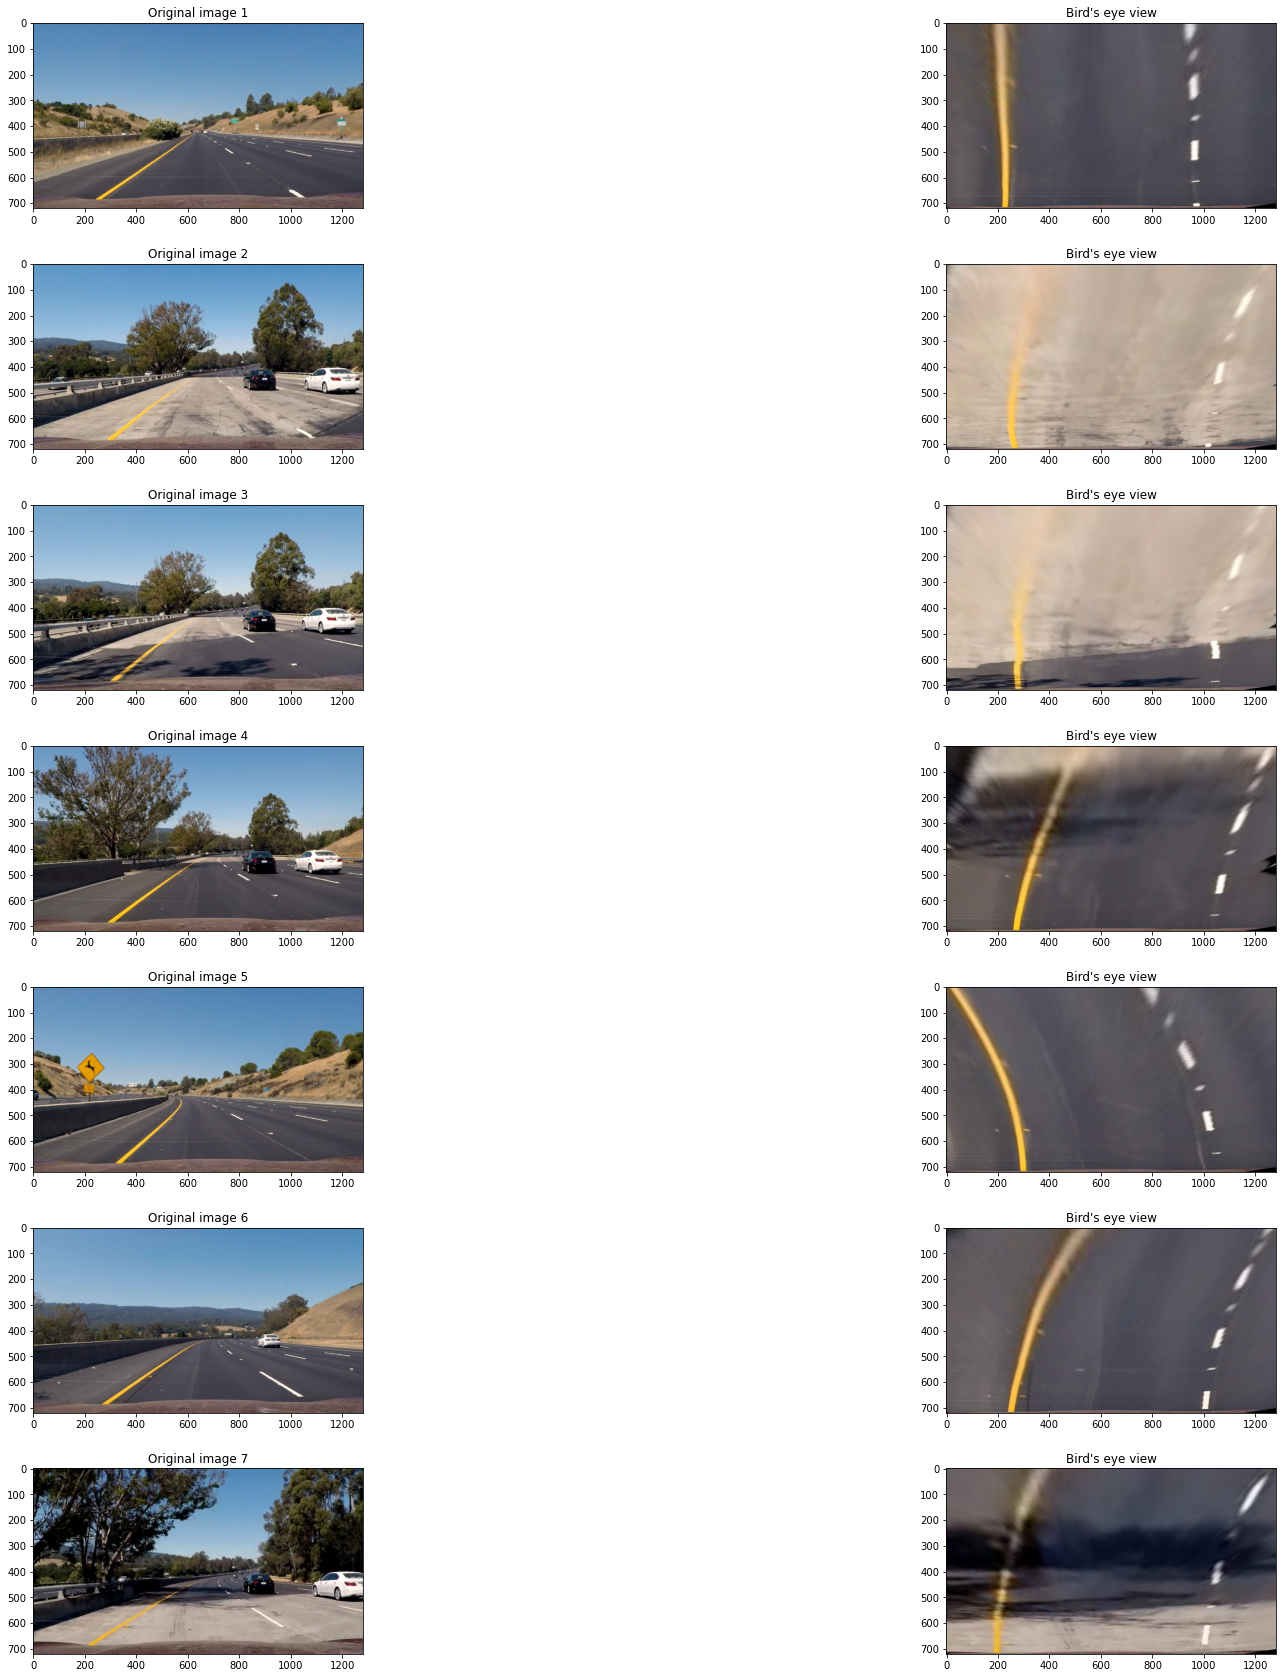

In [54]:
'''creating numpy array of output images and show them'''
Unwarped_images=[]
f,axes= plt.subplots(len(test_images),2, figsize=(30,30))
f.subplots_adjust(hspace=0.3)
row=0
for image in test_images :
    mat,inv=PerspectiveTransform(src,dst)
    unwarped_image= WarpImg(image,mat)
    Unwarped_images.append(unwarped_image)
    y=image.shape[0]
    x=image.shape[1]
    axes[row,0].imshow(image)
    axes[row,0].set_title('Original image '+str(row+1))
    axes[row,1].imshow(unwarped_image)
    axes[row,1].set_title("Bird's eye view")
    row+=1   

# Sobel Filtering

### It is one of the main factors that can detect the lines of the lane especially, if they are colored.
### Lane lines typically have a high contrast to the road, so we can use this to our advantage.
We'll still be using the HLS Colorspace again, this time to detect changes in Saturation and Lightness. The sobel operators are applied to these two channels, and we extract the gradient with respect to the x axis, and add the pixels which pass our gradient threshold to a binary matrix representing the pixels in our image.


## Sobel X,Y

In [55]:
def sobel_image(img, orient='x',thresh_min=0, thresh_max=255, convert=True):
    
    
    gray= img
    if(convert):
        gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobel=None
    
    #we're interested mainly on vertical lines
    if(orient=='x'):
        #To calculate the gradient in x direction so the filter has the -ve numbers on the left col
        # The depth of the output image is cv2.CV_64F to get 2D Floated Matrix
        #By default the kernel size is 3x3
        sobel= cv2.Sobel(gray, cv2.CV_64F, 1,0,ksize=3)
    else:
        #To calculate the gradient in y direction so the filter has the -ve numbers on the bottom row
        sobel= cv2.Sobel(gray, cv2.CV_64F, 0,1,ksize=sobel_kernel)
    
    #Scaling
    sobel_abs= np.absolute(sobel) # Absolute x/y derivative to accentuate lines away from horizontal/vertical
    #to get the range from 0 to 255
    sobel_8bit= np.uint8(255* sobel_abs/np.max(sobel_abs))
    binary_output= np.zeros_like(sobel_8bit) 
    binary_output[(sobel_8bit>=thresh_min) & (thresh_max>=sobel_8bit)]=1
    
    return binary_output

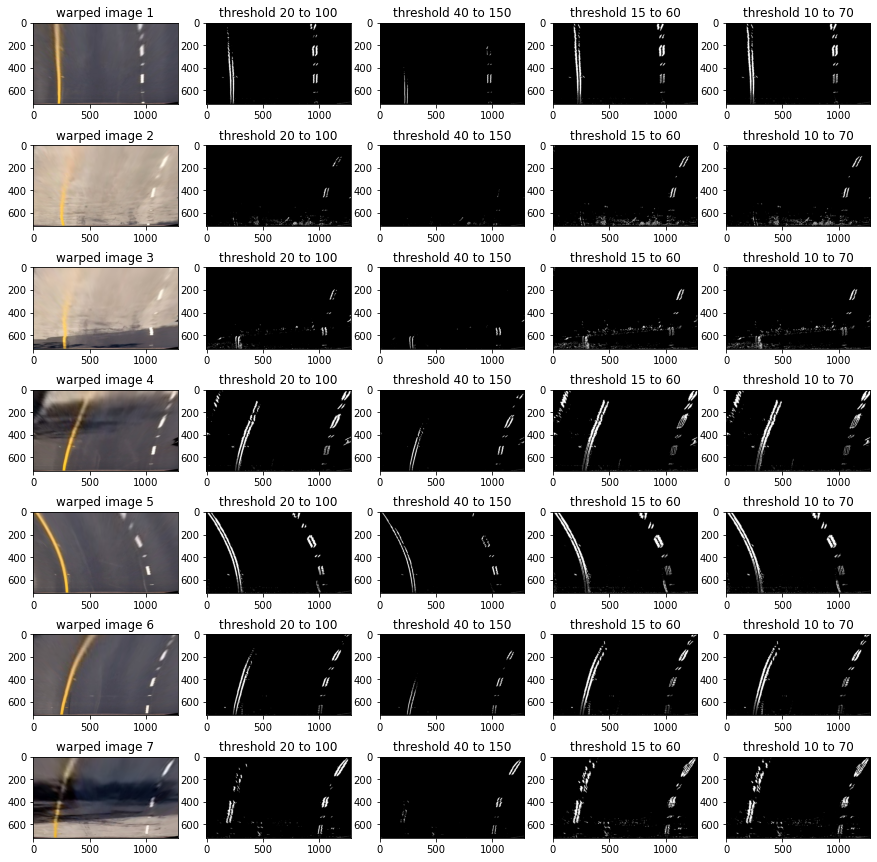

In [56]:
threshVal= [(20,100),(40,150),(15,60),(10,70)]
#Unwrap folder of eyebirds images
f,axes= plt.subplots(len(Unwarped_images),5, figsize=(15,15))
# hspace = the amount of height reserved for space between subplots
f.subplots_adjust(hspace =0.5)
row=0

for image in Unwarped_images:
    
    axes[row,0].imshow(image)
    axes[row,0].set_title('warped image '+str(row+1))
    #image= cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    
    sobel_applied_image1= sobel_image(image, 'x', threshVal[0][0], threshVal[0][1], True)
    axes[row,1].imshow(sobel_applied_image1,cmap='gray')
    axes[row,1].set_title('threshold '+str(threshVal[0][0])+' to '+str(threshVal[0][1]))
    
    sobel_applied_image2= sobel_image(image, 'x', threshVal[1][0], threshVal[1][1], True)
    axes[row,2].imshow(sobel_applied_image2,cmap='gray')
    axes[row,2].set_title('threshold '+str(threshVal[1][0])+' to '+str(threshVal[1][1]))
    
    sobel_applied_image3= sobel_image(image, 'x', threshVal[2][0], threshVal[2][1], True)
    axes[row,3].imshow(sobel_applied_image3,cmap='gray')
    axes[row,3].set_title('threshold '+str(threshVal[2][0])+' to '+str(threshVal[2][1]))
    
    sobel_applied_image4= sobel_image(image, 'x', threshVal[3][0], threshVal[3][1], True)
    axes[row,4].imshow(sobel_applied_image3,cmap='gray')
    axes[row,4].set_title('threshold '+str(threshVal[3][0])+' to '+str(threshVal[3][1]))
    
    row+=1

In image 2 and 3, the left lane line is completely getting misidentified. Sobel is identifying road edge as the lane line. This is due to the low contrast between lane line and the bright road in these two images.

## Sobel Magnithude

In [57]:
def sobel_mag(img, thresh, convert=True):
    gray= img
    if(convert):
        gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx= cv2.Sobel(gray, cv2.CV_64F, 1,0)
    sobely= cv2.Sobel(gray, cv2.CV_64F, 0,1)
    
    mag= (sobelx**2+ sobely**2)**(0.5)
    
    #Scaling
    sobel_mag_8bit= np.uint8(255* mag/np.max(mag))
    binary_output= np.zeros_like(sobel_mag_8bit) 
    binary_output[(sobel_mag_8bit>=thresh[0]) & (thresh[1]>=sobel_mag_8bit)]=1
    
    return binary_output

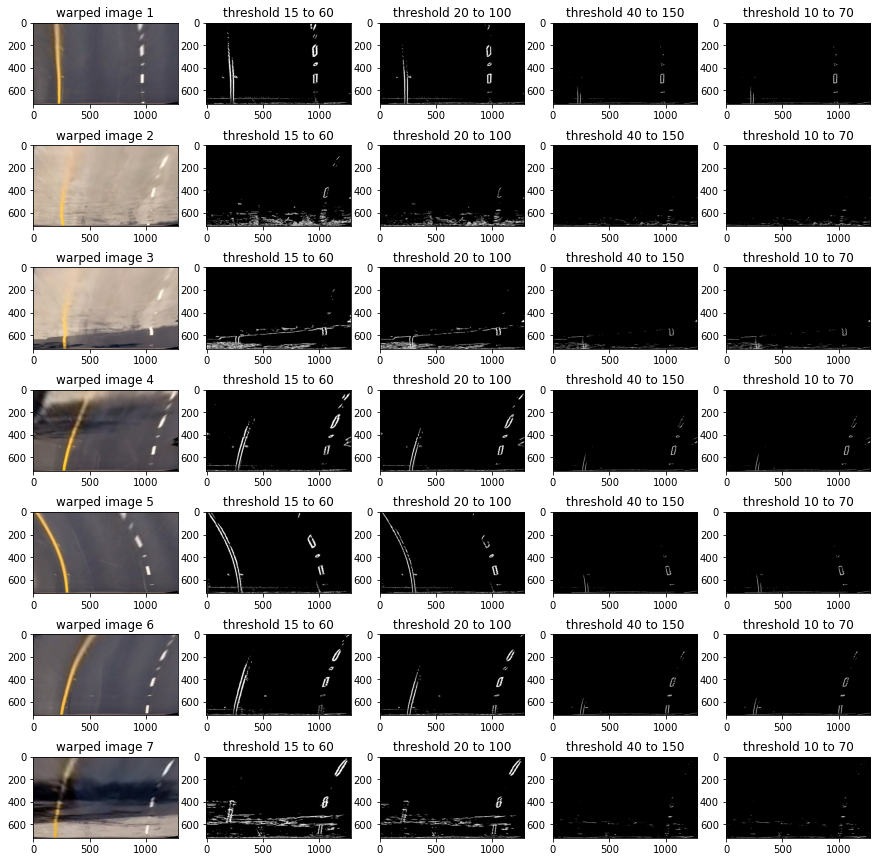

In [58]:
threshMag= [(15,60),(20,100),(40,150),(10,70)]

f,axes= plt.subplots(len(Unwarped_images),5, figsize=(15,15))
f.subplots_adjust(hspace =0.5)
row=0
convert=True
for image in Unwarped_images:
    
    axes[row,0].imshow(image)
    axes[row,0].set_title('warped image '+str(row+1))
#     convert=False
#     image= cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    
    sobel_applied_image1= sobel_mag(image, threshMag[0],convert)
    axes[row,1].imshow(sobel_applied_image1,cmap='gray')
    axes[row,1].set_title('threshold '+str(threshMag[0][0])+' to '+str(threshMag[0][1]))
    
    sobel_applied_image2= sobel_mag(image,  threshMag[1],convert)
    axes[row,2].imshow(sobel_applied_image2,cmap='gray')
    axes[row,2].set_title('threshold '+str(threshMag[1][0])+' to '+str(threshMag[1][1]))
    
    sobel_applied_image3= sobel_mag(image,  threshMag[2],convert)
    axes[row,3].imshow(sobel_applied_image3,cmap='gray')
    axes[row,3].set_title('threshold '+str(threshMag[2][0])+' to '+str(threshMag[2][1]))
    
    sobel_applied_image4= sobel_mag(image,  threshMag[3],convert)
    axes[row,4].imshow(sobel_applied_image3,cmap='gray')
    axes[row,4].set_title('threshold '+str(threshVal[3][0])+' to '+str(threshVal[3][1]))
    
    row+=1

I can't see any improvement in lane detection using sobel magnitude also. Sobel is not able to detect low contrast lane lines and hence will completely fail in bright road conditions.

## Sobel Gradient

In [59]:
def sobel_gradient_image(img, thresh=(0, np.pi/2), convert=True):
    gray= img
    if(convert):
        gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx= cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=15)
    sobely= cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=15)
    
    
    abs_sobelx= np.absolute(sobelx)  # Absolute x derivative to accentuate lines away from horizontal
    abs_sobely= np.absolute(sobely)  # Absolute y derivative to accentuate lines away from vertical
    
    #arctant(filter on y/filter on x)
    grad= np.arctan2(abs_sobely, abs_sobelx)
    
    binary_output=np.zeros_like(grad)
    binary_output[(grad>thresh[0])&(grad<thresh[1])]=1
    return binary_output

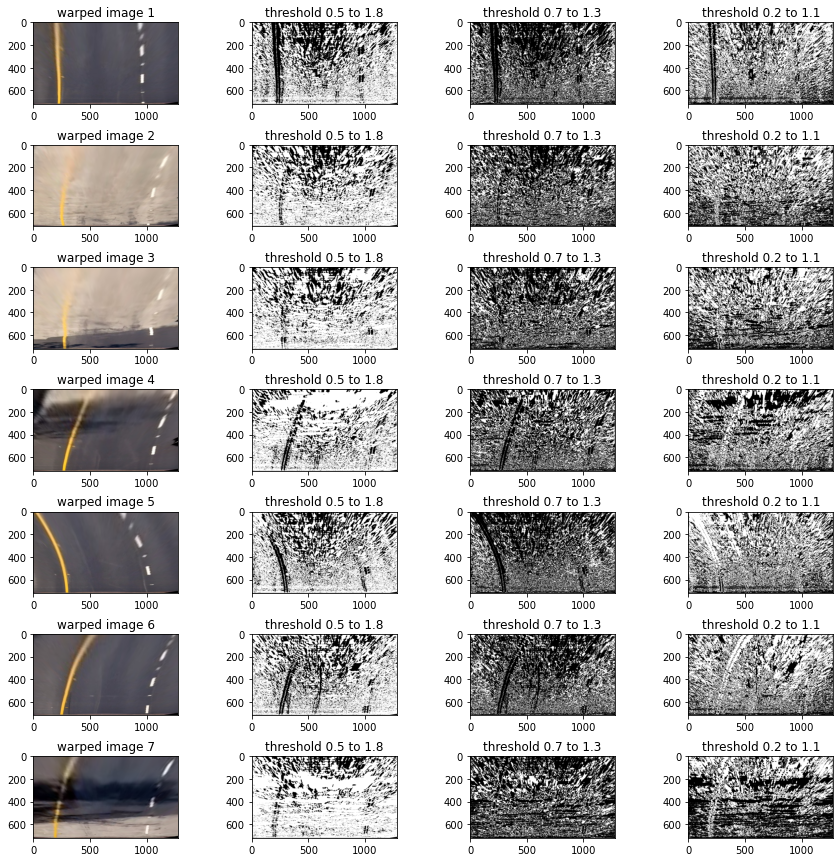

In [60]:
threshGrad= [(0.5,1.8),(0.7,1.3),(0.2,1.1)]

f,axes= plt.subplots(len(Unwarped_images),4, figsize=(15,15))
f.subplots_adjust(hspace =0.5)
row=0
convert=True
for image in Unwarped_images:
    
    axes[row,0].imshow(image)
    axes[row,0].set_title('warped image '+str(row+1))
#     image= cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
#     convert=False
    
    sobel_applied_image1= sobel_gradient_image(image, threshGrad[0], convert)
    axes[row,1].imshow(sobel_applied_image1,cmap='gray')
    axes[row,1].set_title('threshold '+str(threshGrad[0][0])+' to '+str(threshGrad[0][1]))
    
    sobel_applied_image2= sobel_gradient_image(image,  threshGrad[1], convert)
    axes[row,2].imshow(sobel_applied_image2,cmap='gray')
    axes[row,2].set_title('threshold '+str(threshGrad[1][0])+' to '+str(threshGrad[1][1]))
    
    sobel_applied_image3= sobel_gradient_image(image,  threshGrad[2], convert)
    axes[row,3].imshow(sobel_applied_image3,cmap='gray')
    axes[row,3].set_title('threshold '+str(threshGrad[2][0])+' to '+str(threshGrad[2][1]))
    
    row+=1

Gradient sobel in itself doesn't looks good enough to detect lane lines. Also there is lot of noise in the images. I'll further try to combine the sobel techniques along with the color channels to detect lane lines better and to suppress the detection of road edges in bright as well as dark conditions.

## Combining Sobel with appropriate channels

In [62]:
#Apply the sobel on L-Channel and do the threshold on S_channel
def Combined(img, s_thresh=(100, 255), sx_thresh=(15, 255)):

    # Convert to HLS color space and separate the V channel
    h_channel,l_channel,s_channel=CVt2hls(img)
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 1) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

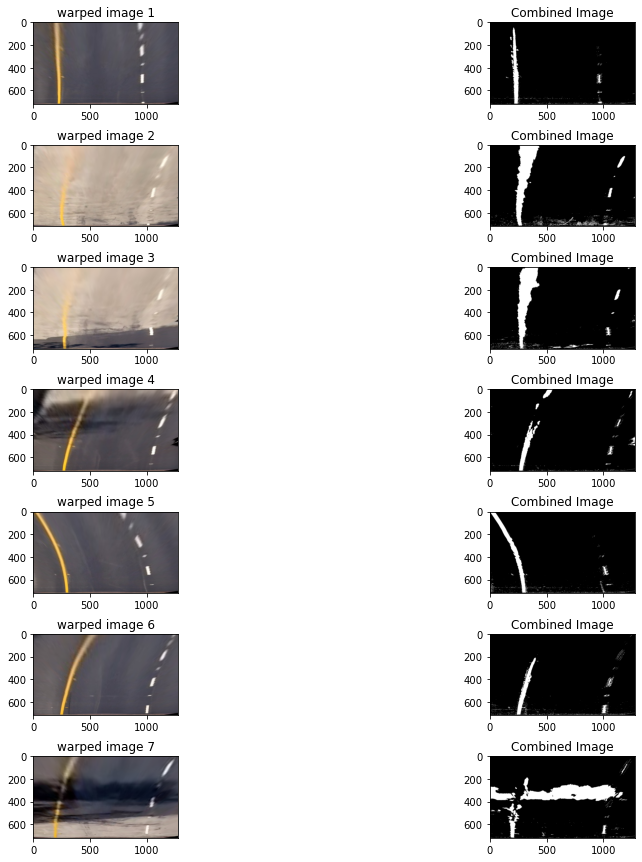

In [64]:
f,axes= plt.subplots(len(Unwarped_images),2, figsize=(15,15))
f.subplots_adjust(hspace =0.5)
row=0
convert=True
for image in Unwarped_images:
    
    axes[row,0].imshow(image)
    axes[row,0].set_title('warped image '+str(row+1))
#     image= cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
#     convert=False
    
    combined_applied_image1= Combined(image)
    axes[row,1].imshow(combined_applied_image1,cmap='gray')
    axes[row,1].set_title("Combined Image")
    
    row+=1